In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image

from cifar_batch import Cifar10Batch
from models import SmallResNet
from utils import read_in_dict, read_labs, get_pics_preds, softmax, get_sorted_ser

from dataset import Pipeline, Dataset, DatasetIndex, B, V, C, F

In [ ]:
%matplotlib inline

In [3]:
# size of cifar-10
SIZE = 50000

In [4]:
# setting up the index and the dataset
index = DatasetIndex(np.arange(SIZE))
cifarset = Dataset(index=index, batch_class=Cifar10Batch)
cifarset.cv_split(0.9)

In [8]:
# read cifar-10 dataset in dict
datadict = read_in_dict(src='D:/Work/OpenData/', components=['images', 'labels', 'picnames'])

In [9]:
testbatch = cifarset.test.p.load(fmt='ndarray', src=datadict).next_batch(500)

### Cats & Dogs from CIFAR-10

* 50000 training examples, 10 classes

In [345]:
# labels
read_labs()

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

* Task: predict prob of each class for a pic

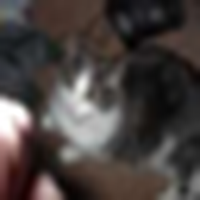

In [423]:
num_pic = 3
itms[num_pic][2]

### Training pipe

In [10]:
train_ppl = (Pipeline()
             .load(fmt='ndarray', src=datadict)
             .init_model('static', SmallResNet, 'smallnet',
                         config=dict(pic_shape=(32, 32), n_channels=3, n_classes=10, loss='ce'))
             .train_model('smallnet', feed_dict={'images': B('images'), 'targets': B('labels')})
             )

In [11]:
cifarpipe = ((cifarset.train >> train_ppl)
             .init_variable('accuracy', init=list)
             .predict_model('smallnet', feed_dict={'images': testbatch.images, 'targets': testbatch.labels},
                            fetches='accuracy', append_to=V('accuracy'))
            )

### Train and save the model

In [12]:
gen = cifarpipe.gen_batch(batch_size=100, n_epochs=None)

In [14]:
N_ITERS = 4000

In [ ]:
for i in tqdm(range(N_ITERS)):
    next(gen)
    if i % 100 == 0:
        print(cifarpipe.get_variable('accuracy')[-1])

In [ ]:
accs = cifarpipe.get_variable('accuracy')

plt.plot(accs[-100:])
plt.xlabel('iters')
plt.ylabel('accuracy')
plt.show()

In [20]:
model = cifarpipe.get_model_by_name('smallnet')

In [21]:
model.save(path='D:\Work\saved_model\cifar\smallres')

### Load saved

In [12]:
pipeload = (cifarset.test.p
             .init_variable('accuracy', init=list)
             .load(fmt='ndarray', src=datadict)
             .init_model('static', TFModel, 'resnet', config=dict(build=False, load=True, graph='model-4000.meta',
                                                                      path='D:\Work\saved_model\cifar\smallres'))
             .predict_model('resnet', feed_dict={'images': testbatch.images, 'targets': testbatch.labels},
                            fetches='accuracy', append_to=V('accuracy'))
           )

INFO:tensorflow:Restoring parameters from D:\Work\saved_model\cifar\smallres\model-4000


In [15]:
model = pipeload.get_model_by_name('resnet')

### See results

In [416]:
p, l, pics = get_pics_preds(testbatch, size=(200, 200))

In [417]:
itms = list(zip(p, l, pics))

In [442]:
num_pic = 18
get_sorted_ser(itms[num_pic])[:3]

True:  truck


truck    1.0
ship     0.0
horse    0.0
dtype: float64

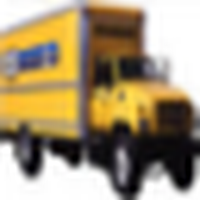

In [443]:
itms[num_pic][2]